<a href="https://colab.research.google.com/github/ashishpatel26/SRCNN_Step_by_Step/blob/main/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !gdown --id 1LukOUfVNeps1Jj7Z27JbkmrO90jwBgie
# !pip install kora
# from kora import drive
# drive.download_folder('1LukOUfVNeps1Jj7Z27JbkmrO90jwBgie')

In [1]:
import shutil
shutil.unpack_archive('mri.zip')

In [2]:
# !ls /content/img_align_celeba

### Load Libraries

In [3]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 93kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [4]:
import glob
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from scipy.misc import imread, imresize
import keras.backend as K
import cv2
import os
from PIL import Image
# from imageio import imread
# from skimage.transform import resize

### Residual Block

In [5]:
def residual_block(x):
    """
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

### Build Generator

In [6]:
def build_generator():
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)

    # Input Layer of the generator network
    input_layer = Input(shape=input_shape)

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model


### Build Descriminator

In [7]:
def build_discriminator():
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 3)

    input_layer = Input(shape=input_shape)

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

### Build VGG19

In [8]:
def build_vgg():
    """
    Build VGG network to extract image features
    """
    input_shape = (256, 256, 3)

    # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    vgg.outputs = [vgg.layers[20].output]

    # Create a Keras model
    model = Model(vgg.input, vgg.outputs)
    return model


# def build_vgg():
#     """
#     Build VGG network to extract image features
#     """
#     input_shape = (256, 256, 3)

#     # Load a pre-trained VGG19 model trained on 'Imagenet' dataset
#     vgg = VGG19(include_top=False, weights='imagenet')
#     vgg.outputs = [vgg.layers[20].output]

#     input_layer = Input(shape=input_shape)

#     # Extract features
#     features = vgg(input_layer)

#     # Create a Keras model
#     model = Model(inputs=[input_layer], outputs=[features])
#     return model

In [10]:
model = build_vgg()
model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

### Sample Images

In [11]:
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
    # Make a list of all images inside the data directory
    all_images = glob.glob(data_dir)

    # Choose a random batch of images
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
        # Get an ndarray of the current image
        img1 = imread(img, mode='RGB')
        img1 = img1.astype(np.float32)

        # Resize the image
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)

        # Do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)

### Save Images

In [12]:
def compute_psnr(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype = tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype = tf.float32)
    
    psnr = tf.image.psnr(original_image, generated_image, max_val = 1.0)
    
    return tf.math.reduce_mean(psnr, axis = None, keepdims = False, name = None)

def plot_psnr(psnr):
    
    psnr_means = psnr['psnr_quality']
    plt.figure(figsize = (10,8))
    
    plt.plot(psnr_means)
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.title('PSNR')
    
def compute_ssim(original_image, generated_image):
  
  original_image = tf.convert_to_tensor(original_image, dtype = tf.float32)
  generated_image = tf.convert_to_tensor(generated_image, dtype = tf.float32)
  
  ssim = tf.image.ssim(original_image, generated_image, max_val = 1.0, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, )
  
  return tf.math.reduce_mean(ssim, axis = None, keepdims = False, name = None)

def plot_ssim(ssim):
    
    ssim_means = ssim['ssim_quality']
    
    plt.figure(figsize = (10,8))
    plt.plot(ssim_means)
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.title('SSIM')

def plot_loss(losses):
    
    d_loss = losses['d_history']
    g_loss = losses['g_history']
    
    plt.figure(figsize = (10,8))
    plt.plot(d_loss, label = "Discriminator loss")
    plt.plot(g_loss, label = "Generator Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.title("Loss")
    plt.legend()

In [44]:
def save_images(low_resolution_image, original_image, generated_image, path, psnr,  ssim):
    """
    Save low-resolution, high-resolution(original) and
    generated high-resolution images in a single image
    """
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution ")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title(f"High-resolution\nPSNR : {psnr}")
    # ax.set_xlabel(f"PSNR : {psnr}")
    # ax.save(hr_path,bbox_inches='tight',transparent=True, pad_inches=0)

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.squeeze(generated_image), cmap = plt.get_cmap(name = 'gray'))
    ax.axis("off")
    ax.set_title(f"Generated\nSSIM : {ssim}" )
    # ax.set_xlabel(f"SSIM : {ssim}")
    # ax.save(pr_path, bbox_inches='tight',transparent=True, pad_inches=0)

    plt.savefig(path)

### Write a Log

In [45]:
from PIL import Image
from skimage.metrics import structural_similarity as ssim

### Final SRGAN Execution

In [50]:
losses = {'d_history' : [], "g_history": []}
psnr = {'psnr_quality' : []}
ssim = {'ssim_quality' : []}

In [53]:
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:0
D_loss : [0.29709604 0.421875  ]
G_loss : [0.08928631246089935, 0.5319599509239197, 0.08875435590744019]
PSNR : 4.699999809265137
SSIM: 0.20000000298023224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:100
D_loss : [7.57343951e-05 1.00000000e+00]
G_loss : [0.037767015397548676, 0.0053010256960988045, 0.037761714309453964]
PSNR : 6.139999866485596
SSIM: 0.6399999856948853


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:200
D_loss : [5.6418e-05 1.0000e+00]
G_loss : [0.03111220709979534, 0.026584092527627945, 0.031085623428225517]
PSNR : 8.90999984741211
SSIM: 0.7699999809265137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:300
D_loss : [1.23228051e-05 1.00000000e+00]
G_loss : [0.03773963823914528, 0.013809883035719395, 0.03772582858800888]
PSNR : 6.960000038146973
SSIM: 0.6399999856948853


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:400
D_loss : [2.11642355e-05 1.00000000e+00]
G_loss : [0.035021014511585236, 0.01149099599570036, 0.03500952199101448]
PSNR : 4.090000152587891
SSIM: 0.6600000262260437


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:500
D_loss : [6.2563247e-06 1.0000000e+00]
G_loss : [0.04119604825973511, 0.010129554197192192, 0.04118591919541359]
PSNR : 6.019999980926514
SSIM: 0.6200000047683716


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:600
D_loss : [0.3827775 0.6171875]
G_loss : [0.044394973665475845, 0.00976214837282896, 0.04438520967960358]
PSNR : 6.380000114440918
SSIM: 0.6299999952316284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:700
D_loss : [0.38278731 0.6171875 ]
G_loss : [0.03921660780906677, 0.0014453560579568148, 0.03921516239643097]
PSNR : 7.239999771118164
SSIM: 0.6499999761581421


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:800
D_loss : [0.05668296 0.94335938]
G_loss : [0.048006344586610794, 3.6218974590301514, 0.04438444599509239]
PSNR : 3.5999999046325684
SSIM: 0.6499999761581421


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---------------
Epoch:900
D_loss : [0.05665756 0.94335938]
G_loss : [0.0368795208632946, 3.490208387374878, 0.03338931128382683]
PSNR : 8.420000076293945
SSIM: 0.6800000071525574



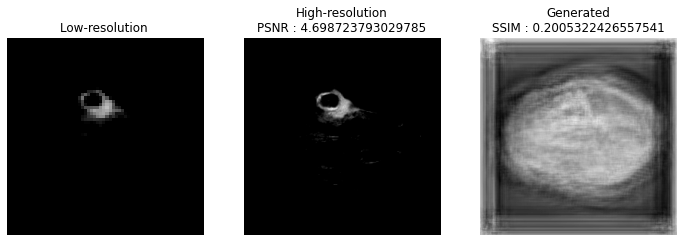

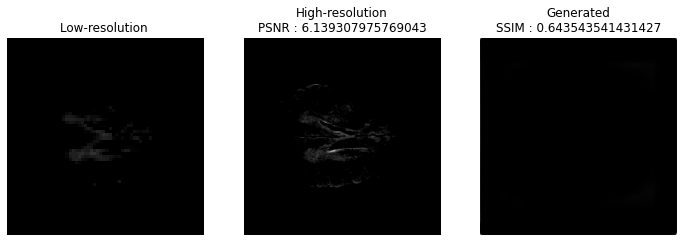

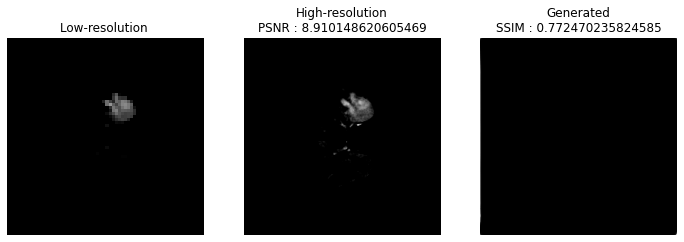

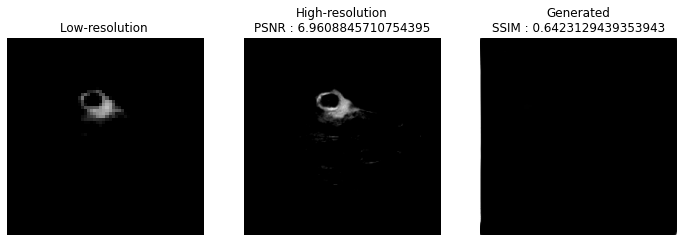

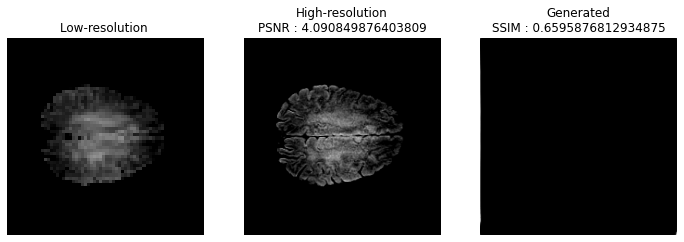

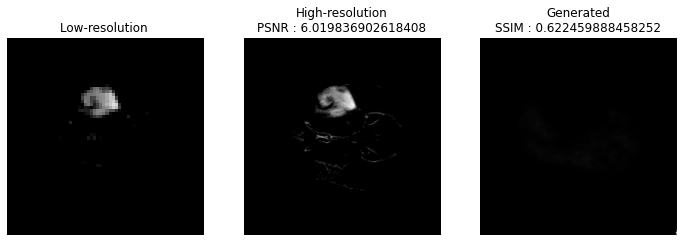

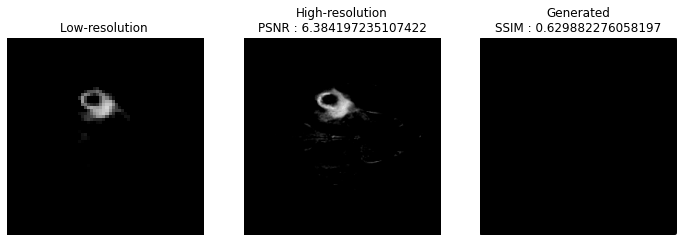

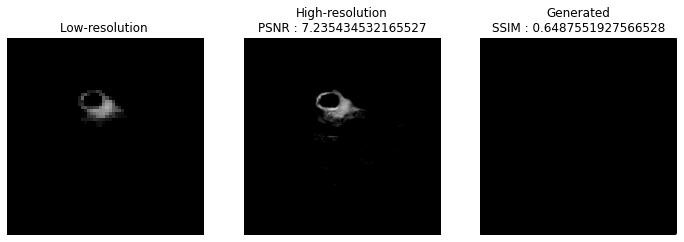

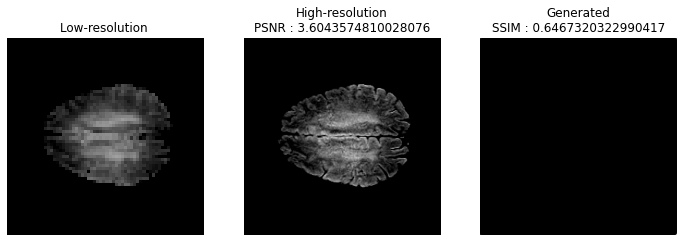

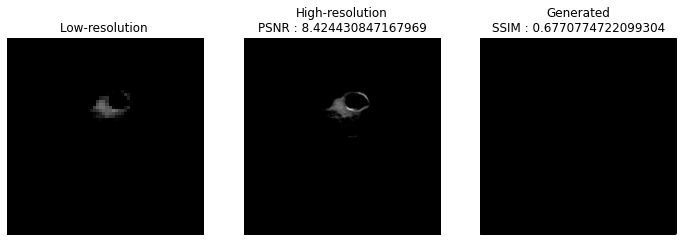

In [54]:
data_dir = "/content/train/*.*"
os.makedirs("results", exist_ok=True)
# os.makedirs("HR", exist_ok=True)
# os.makedirs("PR", exist_ok=True)
# os.makedirs("LR", exist_ok=True)

epochs = 1000
batch_size = 1
mode = 'train'

# Shape of low-resolution and high-resolution images
low_resolution_shape = (64, 64, 3)
high_resolution_shape = (256, 256, 3)

# Common optimizer for all networks
common_optimizer = Adam(0.0002, 0.5)

if mode == 'train':
    # Build and compile VGG19 network to extract features
    vgg = build_vgg()
    vgg.trainable = False
    vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # Build and compile the discriminator network
    discriminator = build_discriminator()
    discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # Build the generator network
    generator = build_generator()

    """
    Build and compile the adversarial model
    """

    # Input layers for high-resolution and low-resolution images
    input_high_resolution = Input(shape=high_resolution_shape)
    input_low_resolution = Input(shape=low_resolution_shape)

    # Generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator(input_low_resolution)

    # Extract feature maps of the generated images
    features = vgg(generated_high_resolution_images)

    # Make the discriminator network as non-trainable
    discriminator.trainable = False

    # Get the probability of generated high-resolution images
    probs = discriminator(generated_high_resolution_images)

    # Create and compile an adversarial model
    adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
    adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)

    # Add Tensorboard
    tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
    tensorboard.set_model(generator)
    tensorboard.set_model(discriminator)

    for epoch in tqdm(range(epochs)):
        # print("Epoch:{}".format(epoch))

        """
        Train the discriminator network
        """

        # Sample a batch of images
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                      low_resolution_shape=low_resolution_shape,
                                                                      high_resolution_shape=high_resolution_shape)
        # Normalize images
        high_resolution_images = high_resolution_images / 127.5 - 1.
        low_resolution_images = low_resolution_images / 127.5 - 1.

        # Generate high-resolution images from low-resolution images
        generated_high_resolution_images = generator.predict(low_resolution_images)

        # Generate batch of real and fake labels
        real_labels = np.ones((batch_size, 16, 16, 1))
        fake_labels = np.zeros((batch_size, 16, 16, 1))

        # Train the discriminator network on real and fake images
        d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

        # Calculate total discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # print("d_loss:", d_loss)

        """
        Train the generator network
        """

        # Sample a batch of images
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                      low_resolution_shape=low_resolution_shape,
                                                                      high_resolution_shape=high_resolution_shape)
        # Normalize images
        high_resolution_images = high_resolution_images / 127.5 - 1.
        low_resolution_images = low_resolution_images / 127.5 - 1.

        # Extract feature maps for real high-resolution images
        image_features = vgg.predict(high_resolution_images)

        # Train the generator network
        g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images], [real_labels, image_features])

        # print("g_loss:", g_loss)

        # Write the losses to Tensorboard
        # write_log(tensorboard, 'g_loss', g_loss[0], epoch)
        # write_log(tensorboard, 'd_loss', d_loss[0], epoch)

        # Sample and save images after every 100 epochs
        if epoch % 100 == 0:
            high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                          low_resolution_shape=low_resolution_shape,
                                                                          high_resolution_shape=high_resolution_shape)
            # Normalize images
            high_resolution_images = high_resolution_images / 127.5 - 1.
            low_resolution_images = low_resolution_images / 127.5 - 1.

            generated_images = generator.predict_on_batch(low_resolution_images)
            ps = compute_psnr(high_resolution_images, generated_images)
            ss = compute_ssim(high_resolution_images, generated_images)
            print("-"*15)
            print("Epoch:{}".format(epoch))
            print(f"D_loss : {d_loss}")  
            print(f"G_loss : {g_loss}")  
            print(f"PSNR : {np.around(ps,decimals=2)}")  
            print(f"SSIM: {np.around(ss,decimals=2)}")

            #***************************************
            # Store into list
            #***************************************
            losses['d_history'].append(d_loss)
            g_loss = 0.5 * (g_loss[1])
            losses['g_history'].append(g_loss)
            psnr['psnr_quality'].append(ps)
            ssim['ssim_quality'].append(ss)


            for index, img in enumerate(generated_images):
                img = np.mean(img, axis=2)
                save_images(low_resolution_images[index], high_resolution_images[index], img, path="/content/results/img_{}_{}".format(epoch, index),  psnr=ps, ssim=ss)
                # gn_im = np.squeeze(img).astype(np.float16)
                # hr_im = high_resolution_images[index].astype(np.float16)
                # lr_im = low_resolution_images[index].astype(np.float16) 
                # psnr = psnr(hr_im,gn_im).numpy()
                # ssim_Score = ssim(hr_im,gn_im, multichannel=True)
                # print("PSNR : ", psnr)
                # print("SSIM Loss : ", ssim_Score)
                  
                
                # plt.imshow(np.squeeze(img), cmap = plt.get_cmap(name = 'gray'))
                # plt.axis('off')
                # plt.savefig(f"PR/im_PR_{epoch}_{index}.png", dpi=100, pad_inches=0.0, bbox_inches='tight')
                # plt.clf()

                # plt.imshow(high_resolution_images[index])
                # plt.axis('off')
                # plt.savefig(f"HR/im_HR_{epoch}_{index}.png", dpi=100, pad_inches=0.0, bbox_inches='tight')
                # plt.clf()

                # plt.imshow(low_resolution_images[index])
                # plt.axis('off')
                # plt.savefig(f"LR/im_LR_{epoch}_{index}.png", dpi=100, pad_inches=0.0, bbox_inches='tight')
                # plt.clf()

                

    # Save models
    generator.save_weights("generator.h5")
    discriminator.save_weights("discriminator.h5")

if mode == 'predict':
    # Build and compile the discriminator network
    discriminator = build_discriminator()

    # Build the generator network
    generator = build_generator()

    # Load models
    generator.load_weights("generator.h5")
    discriminator.load_weights("discriminator.h5")

    # Get 10 random images
    high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=10,
                                                                  low_resolution_shape=low_resolution_shape,
                                                                  high_resolution_shape=high_resolution_shape)
    # Normalize images
    high_resolution_images = high_resolution_images / 127.5 - 1.
    low_resolution_images = low_resolution_images / 127.5 - 1.

    # Generate high-resolution images from low-resolution images
    generated_images = generator.predict_on_batch(low_resolution_images)
    # generated_images = cv2.cvtColor(generated_images, cv2.COLOR_BGR2GRAY)
    
    # Save images
    for index, img in enumerate(generated_images):
        img = np.mean(img, axis=2)
        # save_images(low_resolution_images[index], high_resolution_images[index], img, path="/content/results/gen_{}".format(index))

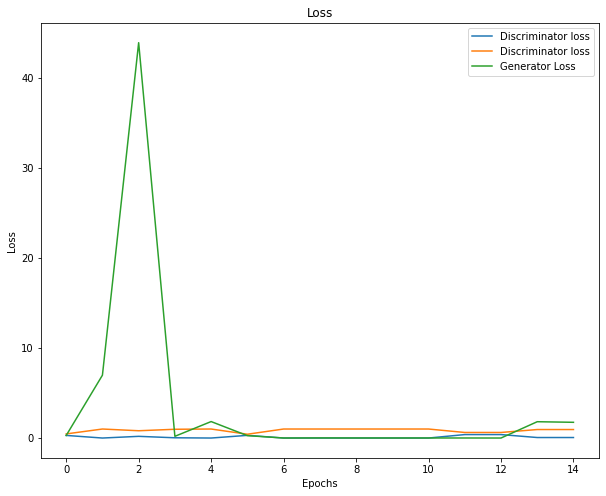

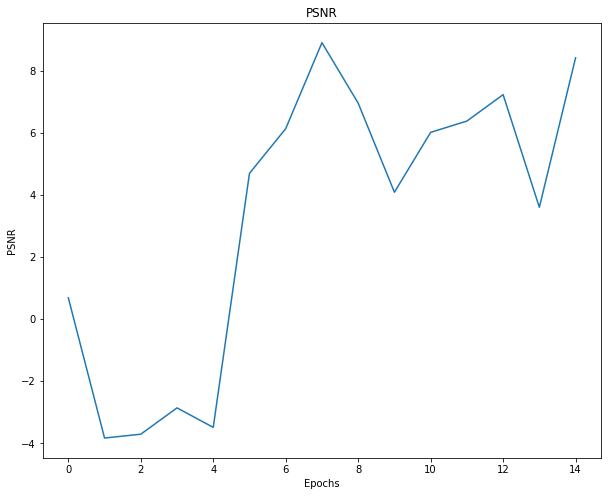

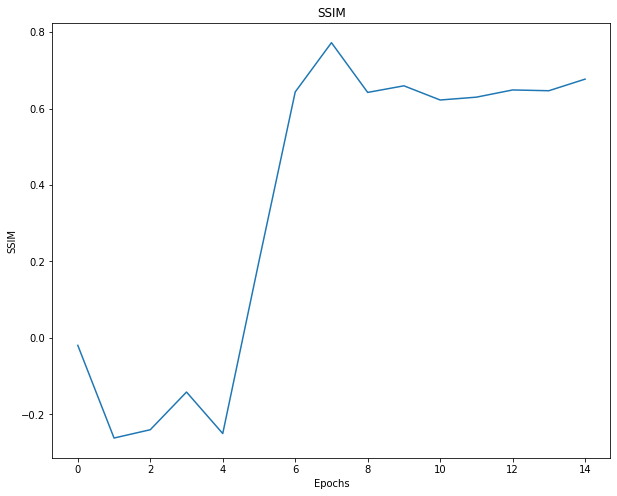

In [55]:
plot_loss(losses)
plot_psnr(psnr)
plot_ssim(ssim)

In [56]:
!zip -r results.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/img_400_0.png (deflated 10%)
  adding: content/results/img_700_0.png (deflated 18%)
  adding: content/results/img_900_0.png (deflated 21%)
  adding: content/results/img_0_0.png (deflated 6%)
  adding: content/results/img_800_0.png (deflated 11%)
  adding: content/results/img_300_0.png (deflated 14%)
  adding: content/results/img_500_0.png (deflated 13%)
  adding: content/results/img_200_0.png (deflated 15%)
  adding: content/results/img_600_0.png (deflated 15%)
  adding: content/results/img_100_0.png (deflated 11%)
